C:\Users\xueke\AppData\Local\Temp\ipykernel_30684\3141424860.py:123: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'single')
C:\Users\xueke\AppData\Local\Temp\ipykernel_30684\3141424860.py:123: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'single')
C:\Users\xueke\AppData\Local\Temp\ipykernel_30684\3141424860.py:123: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'single')
C:\Users\xueke\AppData\Local\Temp\ipykernel_30684\3141424860.py:123: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'single')


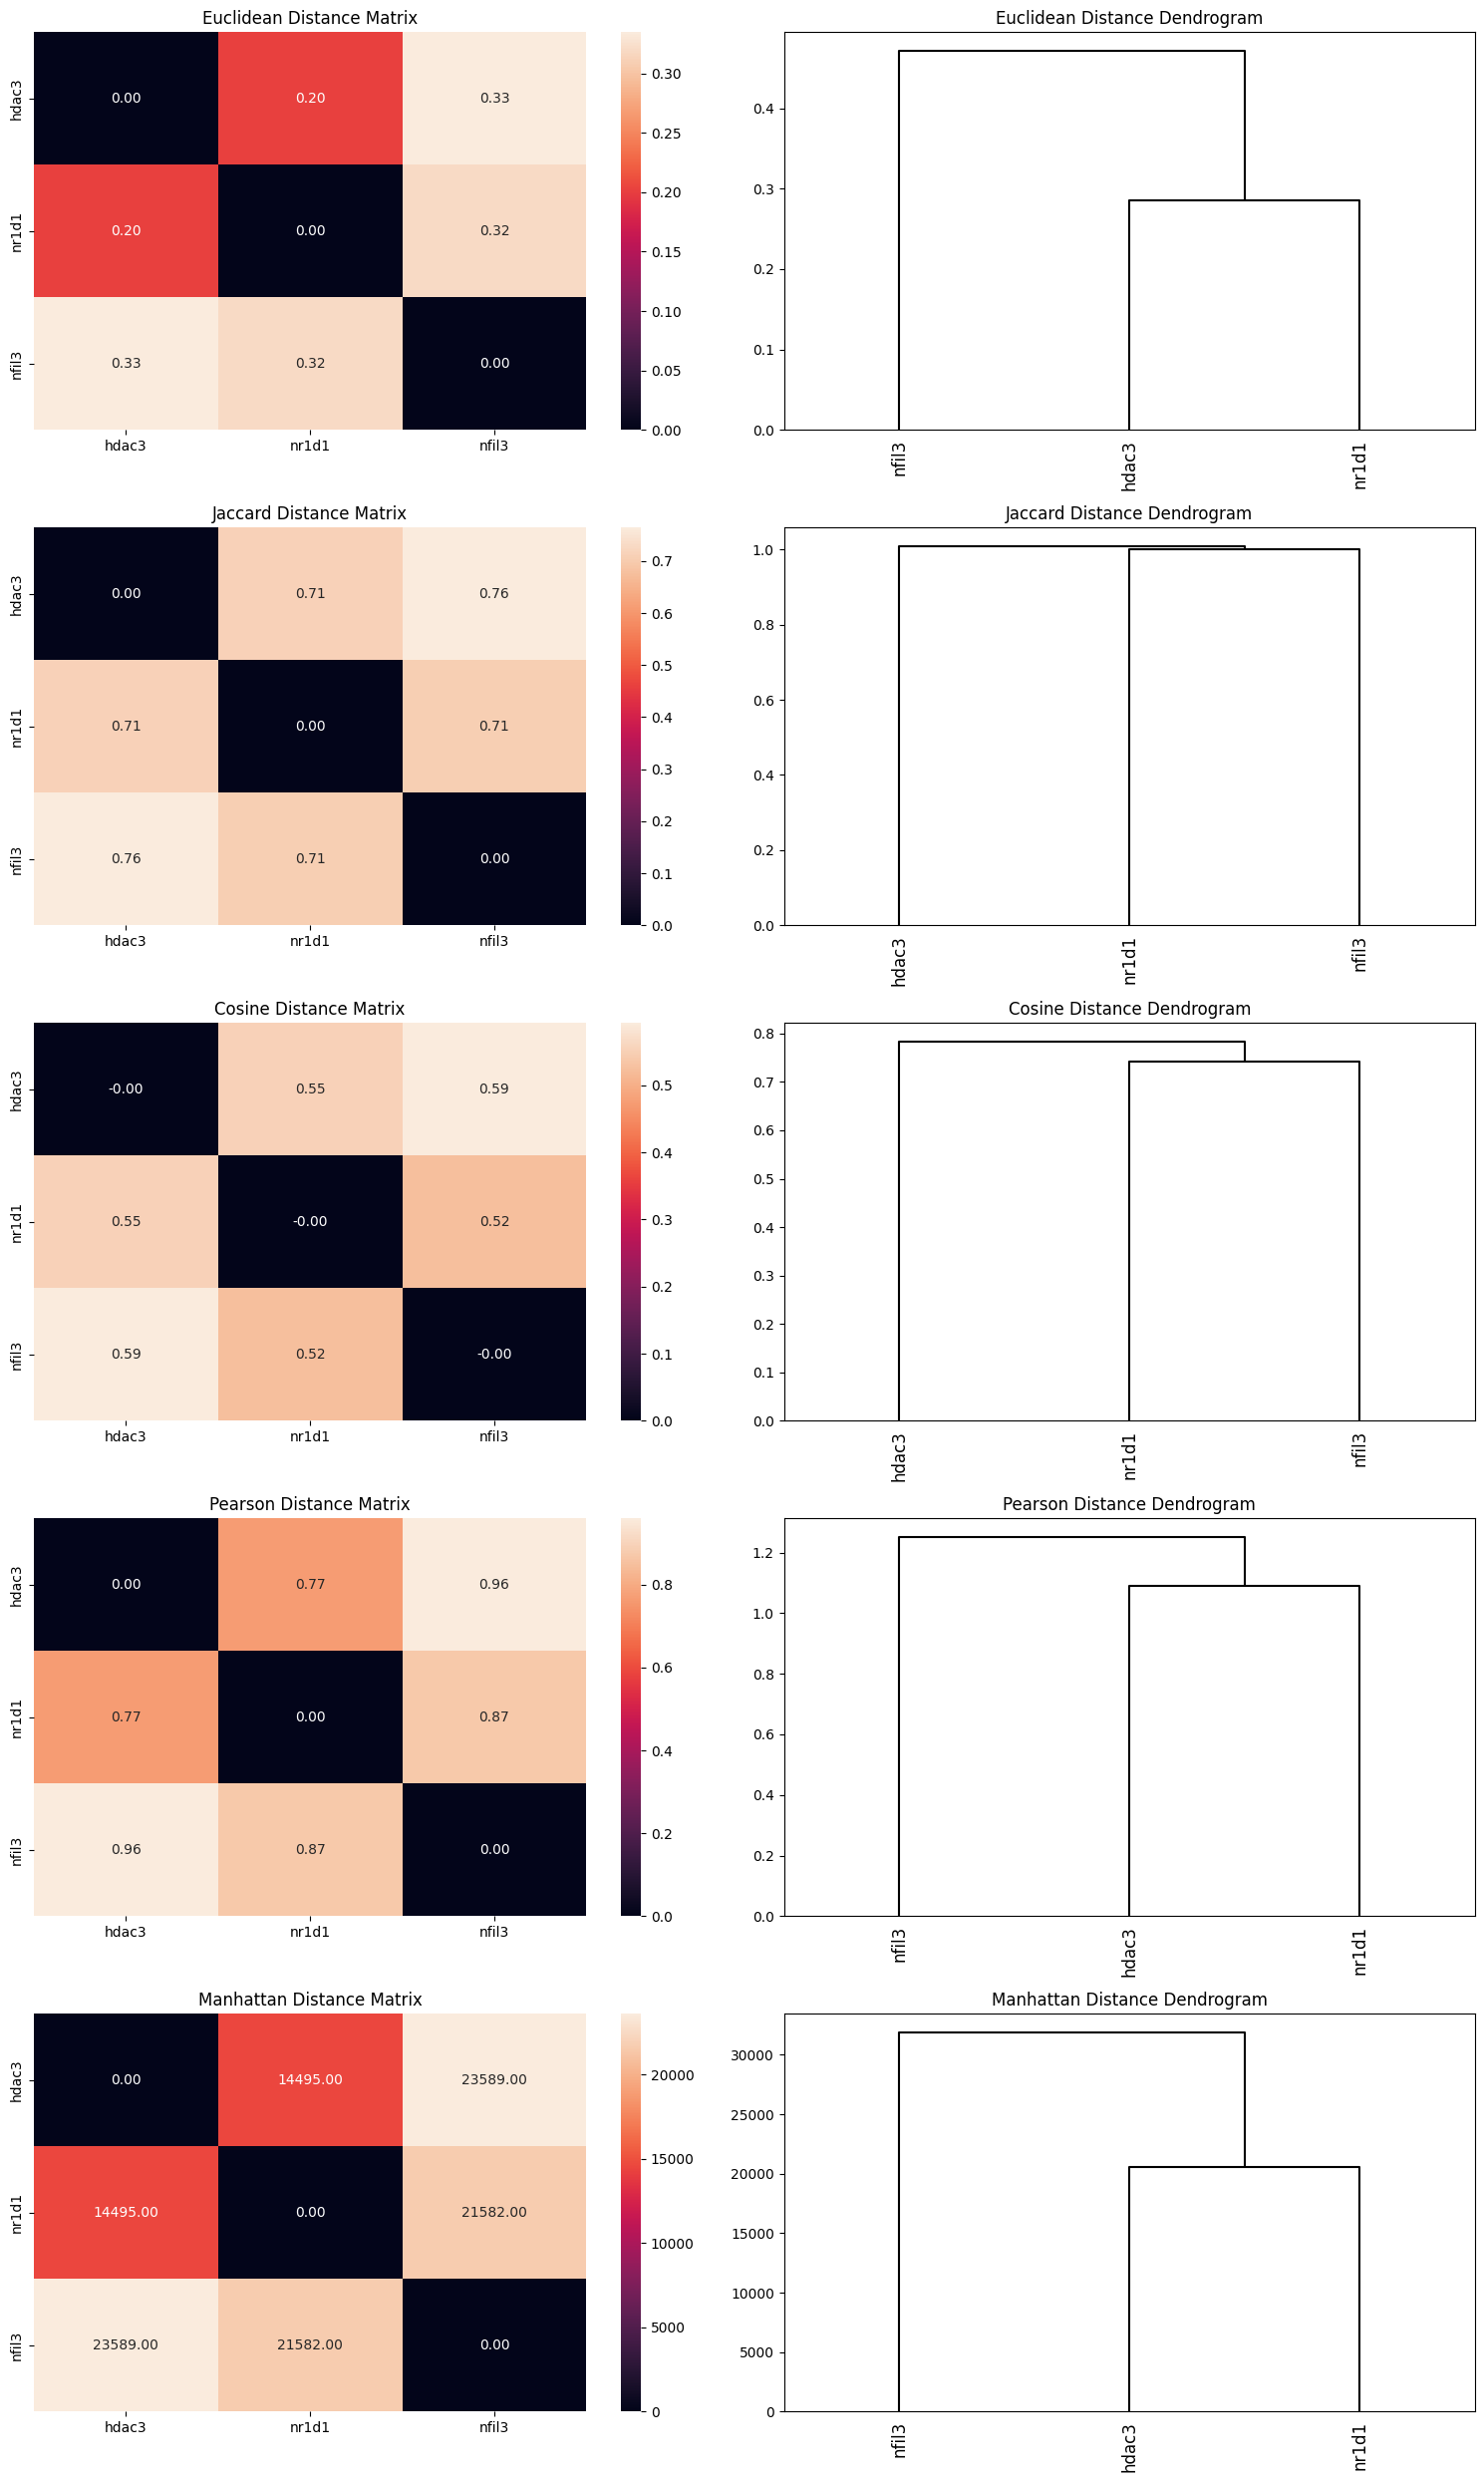

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cityblock, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Function to normalize a single column
def normalize_col(column):
    return (column - column.min()) / (column.max() - column.min())

# Function to calculate differences and normalize them
def calculate_and_normalize_differences(df_wt, df_ko):
    raw_amp_diff = df_wt['meta2d_rAMP'] - df_ko['meta2d_rAMP']
    corrected_amp_diff = raw_amp_diff - np.log(np.abs(raw_amp_diff))
    amp_diff_normalized = normalize_col(corrected_amp_diff)
    
    raw_phase_diff = df_wt['meta2d_phase'] - df_ko['meta2d_phase']
    phase_diff_normalized = normalize_col(raw_phase_diff)
    
    return pd.DataFrame({
        'CycID': df_wt['CycID'],
        'amp_diff': amp_diff_normalized,
        'phase_diff': phase_diff_normalized
    })

# Function to convert continuous data to binary based on threshold
def to_binary(df, thresholds):
    binary_df = pd.DataFrame()
    for col in df.columns[1:]:  # Skipping the 'CycID' column
        binary_df[col] = (df[col] > thresholds[col]).astype(int)
    return binary_df

# Gene groups with their corresponding files
gene_groups = [
    ("meta2d_hdac3_WT.txt", "meta2d_hdac3_KO.txt"),
    ("meta2d_nr1d1_WT.txt", "meta2d_nr1d1_KO.txt"),
    ("meta2d_nfil3_WT.txt", "meta2d_nfil3_KO.txt"),
]

# Initialize list for storing processed DataFrames
data_frames = []

# Process each gene group and save differences
for wt_file, ko_file in gene_groups:
    df_wt = pd.read_csv(wt_file, sep='\t')
    df_ko = pd.read_csv(ko_file, sep='\t')
    difference_df = calculate_and_normalize_differences(df_wt, df_ko)
    data_frames.append(difference_df)

# Concatenate the dataframes to calculate global thresholds
all_data = pd.concat([df.iloc[:, 1:] for df in data_frames])

# Calculate thresholds
thresholds = all_data.median()

# Convert data to binary based on thresholds
binary_data = [to_binary(df, thresholds) for df in data_frames]

# Calculate distance matrices
def calc_euclidean_distances(data_frames):
    distance_matrix = np.zeros((len(data_frames), len(data_frames)))
    for i in range(len(data_frames)):
        for j in range(i+1, len(data_frames)):
            dist = np.mean(np.sqrt(np.square(data_frames[i]['amp_diff'] - data_frames[j]['amp_diff']) + 
                                   np.square(data_frames[i]['phase_diff'] - data_frames[j]['phase_diff'])))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    return distance_matrix

def calc_jaccard_distances(binary_data):
    def jaccard_similarity(binary_df1, binary_df2):
        intersection = (binary_df1 & binary_df2).sum().sum()  
        union = (binary_df1 | binary_df2).sum().sum()  
        return intersection / union
    
    distances = np.zeros((len(binary_data), len(binary_data)))
    for i in range(len(binary_data)):
        for j in range(i+1, len(binary_data)):
            sim = jaccard_similarity(binary_data[i], binary_data[j])
            dist = 1 - sim
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def calc_cosine_distances(binary_data):
    cosine_similarities = cosine_similarity([df.values.flatten() for df in binary_data])
    cosine_distances = 1 - cosine_similarities
    return cosine_distances

def calc_pearson_distances(binary_data):
    pearson_corr_matrix = np.corrcoef([df.values.flatten() for df in binary_data])
    pearson_distance_matrix = 1 - pearson_corr_matrix
    return pearson_distance_matrix

def calc_manhattan_distances(binary_data):
    manhattan_distances = np.zeros((len(binary_data), len(binary_data)))
    for i in range(len(binary_data)):
        for j in range(i+1, len(binary_data)):
            dist = cityblock(binary_data[i].values.flatten(), binary_data[j].values.flatten())
            manhattan_distances[i, j] = dist
            manhattan_distances[j, i] = dist
    return manhattan_distances

euclidean_distances = calc_euclidean_distances(data_frames)
jaccard_distances = calc_jaccard_distances(binary_data)
cosine_distances = calc_cosine_distances(binary_data)
pearson_distances = calc_pearson_distances(binary_data)
manhattan_distances = calc_manhattan_distances(binary_data)

# Plotting the heatmaps and dendrograms
distance_matrices = [euclidean_distances, jaccard_distances, cosine_distances, pearson_distances, manhattan_distances]
titles = ['Euclidean Distance', 'Jaccard Distance', 'Cosine Distance', 'Pearson Distance', 'Manhattan Distance']
labels = ["hdac3", "nr1d1", "nfil3"]

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for i, (dist_matrix, title) in enumerate(zip(distance_matrices, titles)):
    sns.heatmap(dist_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, ax=axes[i, 0])
    axes[i, 0].set_title(f'{title} Matrix')
    
    Z = linkage(dist_matrix, 'single')
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=12, ax=axes[i, 1], link_color_func=lambda k: 'black')
    axes[i, 1].set_title(f'{title} Dendrogram')

plt.tight_layout()
plt.show()
